In [207]:
%matplotlib inline
import matplotlib as mpl

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from datetime import datetime
import bisect


In [3]:
def background(p, extent, lon_rho,lat_rho,h, 
               pars=np.arange(18, 35), mers=np.arange(-100, -80), 
               hlevs=np.hstack(([10,20],np.arange(50,500,50))), 
               col='lightgrey', outline=[1, 1, 0, 1], ax=None, fig=None):
    """
    Plot basic TXLA shelf background: coastline, bathymetry, meridians, etc
    pars    parallels to plot
    mers    meridians to plot
    hlevs   which depth contours to plot
    outline     west, east, north, south lines (left, right, top, bottom)
    """
    
    if fig is None:
        fig = plt.gcf()

    if ax is None:
        ax = plt.gca(projection=p)
                           
    ax.set_extent(extent)
    ax.add_feature(cfeature.NaturalEarthFeature( category='physical', name='land', 
                                                scale='10m', 
                                                facecolor='slategrey'))
    ax.add_feature(cfeature.NaturalEarthFeature( category='physical', name='rivers_lake_centerlines', 
                                                scale='10m', 
                                                edgecolor='blue', facecolor='none'))
    ax.add_feature(cfeature.NaturalEarthFeature( category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', 
                                                facecolor='none'))
    ax.coastlines(resolution="10m")   
        
    ax.contour(lon_rho,lat_rho, h, hlevs, colors=col, linewidths=0.5, transform=ccrs.PlateCarree())
    
    
    # Outline numerical domain
    # if outline:  # backward compatibility
    #     outline = [1,1,1,1]
    if outline[3]:
        ax.plot(lon_rho[0,:], lat_rho[0,:], 'k:', transform=ccrs.PlateCarree())
    if outline[2]:
        ax.plot(lon_rho[-1,:], lat_rho[-1,:], 'k:', transform=ccrs.PlateCarree())
    if outline[1]:
        ax.plot(lon_rho[:,-1], lat_rho[:,-1], 'k:', transform=ccrs.PlateCarree())
    if outline[0]:
        ax.plot(lon_rho[:,0], lat_rho[:,0],'k:', transform=ccrs.PlateCarree())
        
    gl = ax.gridlines(xlocs= mers, ylocs=pars, draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.outline_patch.set_visible(False)
     
    return fig, ax

In [307]:
def make_plot(plotdate, cmap):
    """docstring for make_plot"""

    # Set up before plotting
    itmodel = bisect.bisect_left(model_dates, plotdate) # index for model output at this time
    itriver = bisect.bisect_left(r_dates, plotdate) # index for river at this time
    itwind = bisect.bisect_left(w_dates, plotdate) # index for wind at this tdai
    
    # Set up plot
    fig = plt.figure(figsize=(12, 9), dpi=100)
#     fig.subplots_adjust(left=1, right=2, bottom=0, top=1)
    ax = fig.add_axes([0.05, 0.01, 0.95, 0.98], 
                   projection=p)
#     ax = plt.axes(projection=p)
    ax.set_frame_on(False)

    # plot base map
    background(p, extent, lon_rho,lat_rho,h, ax = ax, fig = fig) 

    # Label isobaths
    ax.text(0.85, 0.865, '10 m', transform=ax.transAxes, fontsize=9, color='0.4', rotation=45)
    ax.text(0.88, 0.862, '20'  , transform=ax.transAxes, fontsize=9, color='0.4', rotation=45)
    ax.text(0.87, 0.835, '50'  , transform=ax.transAxes, fontsize=9, color='0.4', rotation=45)
    ax.text(0.89, 0.825, '100' , transform=ax.transAxes, fontsize=9, color='0.4', rotation=45)
    ax.text(0.9 , 0.803, '450' , transform=ax.transAxes, fontsize=9, color='0.4', rotation=45)

    # Date label
    d_lb = pd.to_datetime(model_dates[itmodel]).strftime('%Y - %b - %d %H:%M')
    ax.text(0.02, 0.84, d_lb, fontsize=13, color='0.2', transform=ax.transAxes, 
              bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=0.5))

    # source
    ax.text(0.45, 0.97, "pong.tamu.edu", fontsize=12, color='0.2', transform=ax.transAxes,
           bbox=dict(facecolor='slategrey', edgecolor='none'))
    
    #Plot bottom ox
    mappable = ax.pcolormesh(lon_rho.values, lat_rho.values, btm_ox[itmodel,:,:].values, 
                             transform=ccrs.PlateCarree(), cmap= cmap , vmin=cmin, vmax=cmax)

    # Colorbar in upper left corner
    cax = fig.add_axes([0.06, 0.925, 0.24, 0.020]) #colorbar axes
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label(r'Bottom oxygen [$\mu$M]', fontsize=11, color='0.2', labelpad=-1)
    cb.ax.tick_params(labelsize=11, length=2, color='0.2', labelcolor='0.2') 
    cb.set_ticks(ticks)
    ax.add_patch(mpl.patches.Rectangle( (0.07, 0.905), 0.13, 0.045, transform=ax.transAxes, 
                                       color='slategrey', zorder=3))
    
    ###### Plot Mississippi river discharge rate
    #Frame
    axr = fig.add_axes([0.42, 0.1, 0.53, .15])       
    for axis in ['top','left','right']:
        axr.spines[axis].set_linewidth(0.05)
    axr.spines['bottom'].set_linewidth(0.0)    

    #fill with every time step
    # make background rectangle so lines don't overlap
    axr.fill_between(r_dates[1:itriver+1], Q[1:itriver+1], 
                     alpha=0.5, facecolor='0.4', edgecolor='0.4', zorder=2)
    axr.plot(r_dates[1:itriver], Q[1:itriver], '-', color='0.4')
    axr.plot(r_dates[1:], Q[1:], '-', color='0.4', alpha=0.3)
    axr.plot([r_dates[1], r_dates[-1]], [5, 5], '-', color='0.6', lw=0.5, alpha=1)
    axr.plot([r_dates[1], r_dates[-1]], [10000, 10000], '-', color='0.6', lw=0.5, alpha=0.5)
    axr.plot([r_dates[1], r_dates[-1]], [20000, 20000], '-', color='0.6', lw=0.5, alpha=0.5)
    axr.plot([r_dates[1], r_dates[-1]], [30000, 30000], '-', color='0.6', lw=0.5, alpha=0.5)

    # this makes sure alignment stays consistent in different years
    axr.autoscale(axis='x', tight=True) 
    axr.set_ylim(-1000,45000) 

    #Make ticks for the river plot
    monthdates = [datetime(year, month, 1, 0, 0, 0) for month in np.arange(1,13)]
    mticks = [bisect.bisect_left(r_dates, monthdate) for monthdate in np.asarray(monthdates)]
    mticknames = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

    # labels
    axr.text(r_dates[mticks[-3]]+pd.DateOffset(days=19), 5, '0', fontsize=9, color='0.4', alpha=0.7)
    axr.text(r_dates[mticks[-3]]+pd.DateOffset(days=19), 10000, '10', fontsize=9, color='0.4', alpha=0.7)
    axr.text(r_dates[mticks[-3]]+pd.DateOffset(days=19), 20000, '20', fontsize=9, color='0.4', alpha=0.7)
    axr.text(r_dates[mticks[-3]]+pd.DateOffset(days=19), 30000, r'$30\times10^3$ m$^3$s$^{-1}$', 
             fontsize=9, color='0.4', alpha=0.7)
    axr.text(r_dates[mticks[1]]+pd.DateOffset(days=19), 35000, 'Mississippi discharge', fontsize=10, color='0.2')

    #ticks
    axr.get_xaxis().set_ticklabels([])
    axr.xaxis.set_ticks_position('bottom')

    #add ticks for each month
    axr.set_xticks(r_dates[mticks])
    axr.tick_params('x', width=1.5, color='0.4') # make ticks bigger
    axr.get_yaxis().set_visible(False)
    axr.get_xaxis().set_visible(False)

    #label month ticks
    for i in xrange(len(mticks)):
        axr.text(r_dates[mticks[i]], 1000, mticknames[i], fontsize=9, color='0.2')

    ###### Plot Wind speed time series
    
    #Frame   

    axw = fig.add_axes([0.42, 0.26, 0.53, .15])       
    for axis in ['top','left','right', 'bottom']:
        axw.spines[axis].set_linewidth(0.05)

    axw.fill_between(w_dates[1:itwind+1], wspd[1:itwind+1], alpha=0.5, facecolor='0.4', edgecolor='0.4', zorder=2)
    axw.plot(w_dates[0:itwind], wspd[0:itwind], '-', color='k')
    axw.plot(w_dates[0:], wspd[0:], '-', color='0.4', alpha=0.3)
    axw.plot([w_dates[0], w_dates[-1]], [0, 0], '-', color='0.6', lw=0.5, alpha=1)
    axw.plot([w_dates[0], w_dates[-1]], [5, 5], '-', color='0.6', lw=0.5, alpha=0.5)
    axw.plot([w_dates[0], w_dates[-1]], [10, 10], '-', color='0.6', lw=0.5, alpha=0.5)
    axw.plot([w_dates[0], w_dates[-1]], [15, 15], '-', color='0.6', lw=0.5, alpha=0.5)
    axw.plot([w_dates[0], w_dates[-1]], [20, 20], '-', color='0.6', lw=0.5, alpha=0.5)

    # this makes sure alignment stays consistent in different years
    axw.autoscale(axis='x', tight=True) 
    axw.set_ylim(0,25)

    mticks = [bisect.bisect_left(w_dates, monthdate) for monthdate in np.asarray(monthdates)]

    # labels
    axw.text(w_dates[mticks[-3]]+pd.DateOffset(days=19), 5, '5', fontsize=9, color='0.4', alpha=0.7)
    axw.text(w_dates[mticks[-3]]+pd.DateOffset(days=19), 10, '10', fontsize=9, color='0.4', alpha=0.7)
    axw.text(w_dates[mticks[-3]]+pd.DateOffset(days=19), 15, '15', fontsize=9, color='0.4', alpha=0.7)
    axw.text(w_dates[mticks[-3]]+pd.DateOffset(days=19), 20, r'$20$ m s$^{-1}$', 
             fontsize=9, color='0.4', alpha=0.7)
    axw.text(w_dates[mticks[1]]+pd.DateOffset(days=19), 21, 'Wind speed', fontsize=10, color='0.2')

    #ticks
    axw.get_xaxis().set_ticklabels([])
    axw.xaxis.set_ticks_position('bottom')

    #add ticks for each month
    axw.set_xticks(w_dates[mticks])
    axw.get_yaxis().set_visible(False)

    ###### Plot hipoxic area
    
    #Frame   
    axh = fig.add_axes([0.42, 0.42, 0.53, .15])       
    for axis in ['top','left','right', 'bottom']:
        axh.spines[axis].set_linewidth(0.05)

    axh.plot(model_dates[0:itmodel], np.asarray(area[0:itmodel])/1e6, '-', color='r')
    axh.plot(model_dates, np.asarray(area)/1e6, '-', color='0.4', alpha=0.3)
    axh.plot([model_dates[0], model_dates[-1]], [0, 0], '-', color='0.6', lw=0.5, alpha=1)
    axh.plot([model_dates[0], model_dates[-1]], [10000, 10000], '-', color='0.6', lw=0.5, alpha=0.5)
    axh.plot([model_dates[0], model_dates[-1]], [20000, 20000], '-', color='0.6', lw=0.5, alpha=0.5)
    axh.plot([model_dates[0], model_dates[-1]], [30000, 30000], '-', color='0.6', lw=0.5, alpha=0.5)

    # this makes sure alignment stays consistent in different years
    axh.autoscale(axis='x', tight=True) 
    axh.set_ylim(0,35000)

    mticks = [bisect.bisect_left(model_dates, monthdate) for monthdate in np.asarray(monthdates)]

    # labels
    axh.text(model_dates[mticks[-3]]+pd.DateOffset(days=19), 0, '0', fontsize=9, color='0.4', alpha=0.7)
    axh.text(model_dates[mticks[-3]]+pd.DateOffset(days=19), 10000, '10', fontsize=9, color='0.4', alpha=0.7)
    axh.text(model_dates[mticks[-3]]+pd.DateOffset(days=19), 20000, '20', fontsize=9, color='0.4', alpha=0.7)
    axh.text(model_dates[mticks[-3]]+pd.DateOffset(days=19), 30000, r'$30\times10^3$ km$^2$', 
             fontsize=9, color='0.4', alpha=0.7)
    axh.text(model_dates[mticks[-6]]+pd.DateOffset(days=9), 6000, 'Hipoxic area', fontsize=10, color='0.2')

    #ticks
    axh.get_xaxis().set_ticklabels([])
    axh.xaxis.set_ticks_position('bottom')

    #add ticks for each month
    axh.set_xticks(model_dates[mticks])
    axh.get_yaxis().set_visible(False)

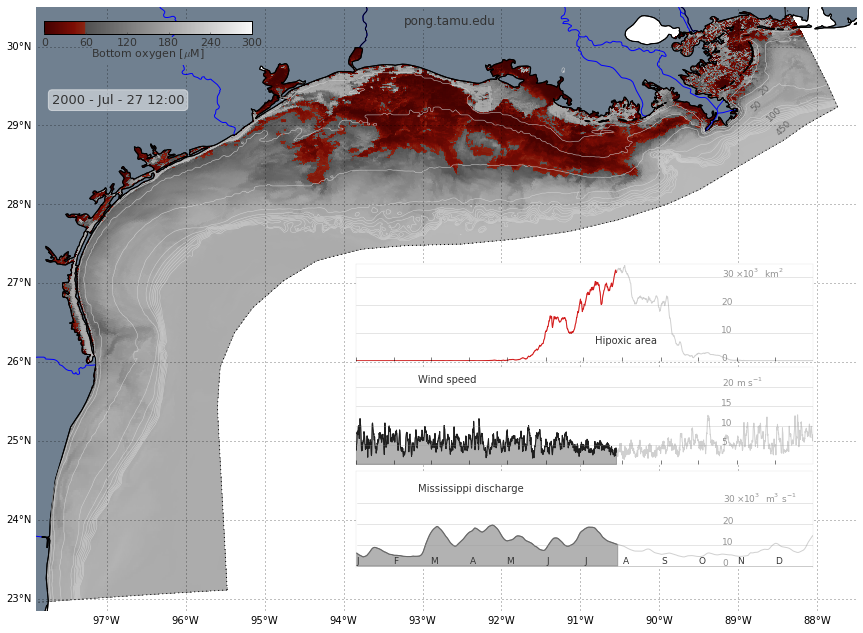

In [308]:
make_plot(plot_dates[5000], cmap_w)
plt.savefig('tumb.png')

In [5]:
#model variable setting
year = 2000
source ='pong'
var = 'dye_01'
z = 0

In [4]:
#PATHS
path= 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
grid_path='http://barataria.tamu.edu:8080/thredds/dodsC/txla_nesting6_grid/txla_grd_v4_new.nc'
river_path= '/Users/vrx/copano/inputs/rivers/txla2_river_'
wind_path= '/Users/vrx/copano/inputs/'
save_path= '/Users/vrx/Projects/xarray_test'

In [8]:
# Grid setting
llcrnrlat=22.85
llcrnrlon=-97.9
urcrnrlat=30.5
urcrnrlon=-87.5
# lat_0 = (llcrnrlat+urcrnrlat)*0.5
lon_0 = (llcrnrlon+urcrnrlon)*0.5
extent=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
p = ccrs.PlateCarree(central_longitude=lon_0)

In [6]:
#Extract model variable data
ds = xr.open_dataset(path)
dsloc = ds.sel(ocean_time=str(year)+'-')
btm_ox = dsloc[var][:,z,:,:]
model_dates = pd.to_datetime(dsloc['ocean_time'].values)
dt = model_dates[1]-model_dates[0]

In [9]:
#Extract grid data
grd = xr.open_dataset(grid_path)
h = grd['h'][:]
lon_rho = grd['lon_rho'][:]
lat_rho = grd['lat_rho'][:]

In [10]:
#Extract river data
rPATH = river_path+str(year)+'_AR_newT_SWpass_weekly.nc'
ds_r = xr.open_dataset(rPATH)
ds_rloc = ds_r.sel(river_time=str(year)+'-')
transport = ds_rloc['river_transport']
Q = np.abs(transport[:,0:43]).sum(axis=1)
r_dates = pd.to_datetime(ds_rloc['river_time'].values)

In [11]:
#Extract wind data
wPATH = wind_path+str(year)+'/txla_bulk_ERAI_'+str(year)+'.nc'
ds_w = xr.open_dataset(wPATH)
ds_wloc = ds_w.sel(time=str(year)+'-')
wspd = ds_wloc['wspd']
w_dates = pd.to_datetime(ds_wloc['time'].values)

In [25]:
wspd = wspd.mean(axis=(1,2)) ### this should be out of any loops. done just once.Takes long

In [7]:
plot_dates = pd.date_range(str(year)+'-01-01 04:00:00', str(year)+'-12-31 23:00:00', 
                           freq=dt.to_pytimedelta())

In [26]:
#oxygen colormap without saturation (take out yellow section)
rgb = np.loadtxt('/Users/vrx/anaconda/lib/python2.7/site-packages/cmocean-0.2-py2.7.egg/cmocean/rgb/Oxygen-rgb.txt')
rgb_new = rgb[:-1,:]
for band in range(rgb.shape[1]):
    rgb_new[51:,band] = np.linspace(rgb[51,band],rgb[204,band], 204)
cmap_w = cmocean.tools.cmap(rgb_new)

In [27]:
#colorbar plot settings
cmap = cmap_w
cmin = 0; cmax = 300; dc = 60
ticks = np.arange(cmin, cmax+dc, dc)
cdx = 7; cdy = 11 # in indices

In [21]:
dA = 1./(grd.pm*grd.pn)
def calc_area(ox, masks, o_crit=60.):
    """get hypoxic area"""
    area = []
    for n in range(ox.shape[0]):
        ox_msk = masks + [np.squeeze(ox[n,:,:])<o_crit]
        total_mask = reduce(np.logical_and, ox_msk)
#         idx = np.where(total_mask)
        area.append(dA.where(total_mask).sum())
    return area

In [22]:
llon = -94.5
rlon = -89.5
hmin = 10.
hmax = 100.

masks = [h>hmin, h<hmax, lon_rho> llon, lon_rho<rlon]
area = calc_area(btm_ox, masks)

# blat = 25.
# masks2 = [grd.h>hmin+5, grd.h<hmax, grd.lat_rho>blat]
# area2 = calc_area(btm_ox, masks2)

In [189]:
import pickle

In [190]:
with open("test.txt", "wb") as fp:
    pickle.dump(rgb_new, fp)
saved_rgb = np.load('test.txt')

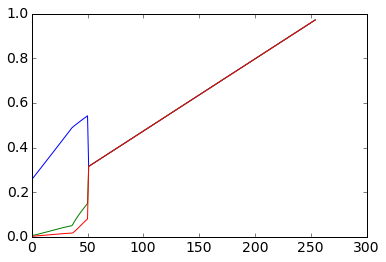

In [192]:
plt.plot(saved_rgb)